In [1]:
# Import Libraries
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Pre-processing
import kardiasclean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# KMeans Cluster
from sklearn.cluster import KMeans

In [2]:
# Load Data
path2 = Path("../database/clean2")
df = pd.read_csv(path2 / "db_patient.csv")
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired
0,0,0,3942,35.0,134.0,0,2001-08-22,2012-04-08,1,2,0
1,1,1,3202,18.0,117.0,0,2003-09-19,2012-11-08,1,2,0
2,2,0,3147,22.0,120.0,0,2003-11-21,2012-08-18,1,2,0
3,3,0,4005,42.0,147.0,0,2001-10-07,2012-08-25,1,2,0
4,4,0,5289,40.0,157.0,0,1997-12-22,2012-01-09,1,3,0


In [3]:
# Exploratory Group Bys
rachs_stay_days_gp = df[["rachs", "stay_days"]].groupby("rachs")
rachs = rachs_stay_days_gp.mean()
rachs["max"] = rachs_stay_days_gp.max()
rachs["min"] = rachs_stay_days_gp.min()

rachs_mortality = df[["rachs", "expired"]].groupby("rachs").sum()
# stay_days_rachs = pd.merge(stay_days_rachs, df["rachs"].value_counts())
rachs_count = df["rachs"].value_counts().sort_index()
rachs["patients"] = df["rachs"].value_counts().sort_values()
rachs["mortality"] = rachs_mortality
rachs["mortality_rate"] = (rachs["mortality"] / rachs["patients"]).map(lambda x: f"{100*x:,.2f}%")
# stay_days_rachs
rachs

,stay_days,max,min,patients,mortality,mortality_rate
rachs,,,,,,
0,17.100000,59,1,20,2,10.00%
1,2.932039,23,1,206,0,0.00%
2,8.591880,364,1,468,10,2.14%
3,13.316964,213,0,224,19,8.48%
4,18.767123,129,0,73,11,15.07%
5,34.000000,34,34,1,0,0.00%
6,67.909091,173,3,11,4,36.36%


In [4]:
# Select feature columns for clustering
columns = [
    "patient_id",
    "gender", 
    "age_days", 
    "weight_kg", 
    "height_cm", 
    "cx_previous",
    "rachs",
    "stay_days",
]
df = df[columns]
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days
0,0,0,3942,35.0,134.0,0,1,2
1,1,1,3202,18.0,117.0,0,1,2
2,2,0,3147,22.0,120.0,0,1,2
3,3,0,4005,42.0,147.0,0,1,2
4,4,0,5289,40.0,157.0,0,1,3


In [5]:
# Load additional columns

df2 = pd.read_csv("../database/clean3/general_diagnosis_categories.csv")
df2.dropna(inplace=True)
df2.head()

,patient_id,diagnosis_general,categories_general
0,0,Ninguno,Ninguno
1,1,Ninguno,Ninguno
2,2,Ninguno,Ninguno
3,3,Ninguno,Ninguno
4,4,Ninguno,Ninguno


In [7]:
# BIN ALL COLUMNS THAT ARE UNDER A QUANTILE THRESHOLD
THRESHOLD = 0.975
df2["categories_general"] = kardiasclean.perform_binning_quantile(df2["categories_general"], THRESHOLD)
encoded_df = kardiasclean.perform_matrix_encoding(df2["categories_general"], df2["patient_id"], append_name=False)
encoded_df.head()

,patient_id,Ninguno,Other,Trisomia 21,Sindrome Dismorfologico E/E,Retraso Psicomotor,Sindrome de Down,Retraso en el desarrollo psicomotor,Retraso global del neurodesarrollo,Madre diabetica,Sx dismorfologico,Hipotiroidismo,Epilepsia,Retraso del neurodesarrollo,ERGE,Hipotiroidismo congenito,Neumopatia cronica,Peso bajo para la edad gestacional,Asplenia
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Merge encoded data with original
merged_df = pd.merge(df, encoded_df)
merged_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,Ninguno,Other,...,Madre diabetica,Sx dismorfologico,Hipotiroidismo,Epilepsia,Retraso del neurodesarrollo,ERGE,Hipotiroidismo congenito,Neumopatia cronica,Peso bajo para la edad gestacional,Asplenia
0,0,0,3942,35.0,134.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,1,0,...,0,0,0,0,0,0,0,0,0,0


PCA

In [9]:
y = merged_df["stay_days"]
X = merged_df.drop(columns=["stay_days"])
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(1003, 25)

0.7893176126821866

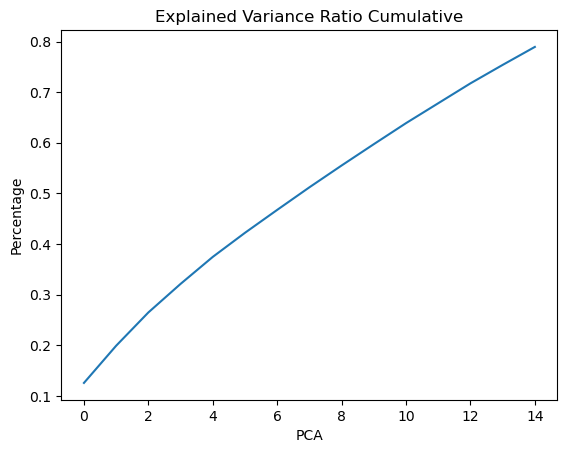

In [10]:
# Evaluate PCA
def get_explained_variance_ratio(df: pd.DataFrame, n_components: int):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(df)
    return data, np.asarray(pca.explained_variance_ratio_)

N_COMPONENTS = 15
data, evr = get_explained_variance_ratio(X_scaled, N_COMPONENTS)
X_pca = pd.DataFrame(data, columns=[f"PC{x+1}" for x in range(N_COMPONENTS)])

plt.plot(np.cumsum(evr))
plt.title("Explained Variance Ratio Cumulative")
plt.xlabel("PCA")
plt.ylabel("Percentage")
sum(evr)

**CONCLUSION:** We are not going to use the PCA, because cleaning was good.

## KMeans Clustering

C:\Users\dani3\anaconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "


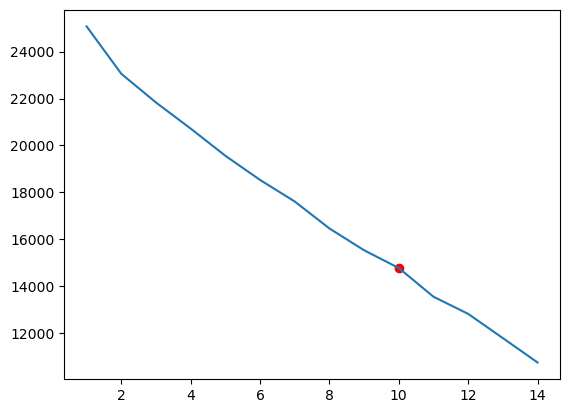

In [11]:
# Plot the Elbow curve
sse = pd.Series({k: KMeans(n_clusters=k).fit(X_scaled).inertia_ for k in range(1, 15)})
N_CLUSTERS = 10
plt.scatter(N_CLUSTERS, sse[N_CLUSTERS], color="red")
plt.plot(sse.index, sse.values)

In [12]:
# Create Clusters
model = KMeans(n_clusters=N_CLUSTERS, random_state=1).fit(X_scaled)
clusters = pd.Series(model.predict(X_scaled))
clusters.value_counts().sort_index()

0    102
1    184
2    377
3    268
4      5
5      5
6      7
7     41
8      5
9      9
dtype: int64

In [13]:
# Merge with ORIGINAL DATA
clustered_df = merged_df.copy(deep=True)
clustered_df["cluster"] = clusters
clustered_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,Ninguno,Other,...,Sx dismorfologico,Hipotiroidismo,Epilepsia,Retraso del neurodesarrollo,ERGE,Hipotiroidismo congenito,Neumopatia cronica,Peso bajo para la edad gestacional,Asplenia,cluster
0,0,0,3942,35.0,134.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,3202,18.0,117.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,3147,22.0,120.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,4005,42.0,147.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
4,4,0,5289,40.0,157.0,0,1,3,1,0,...,0,0,0,0,0,0,0,0,0,1


Text(0, 0.5, 'Average Stay Days')

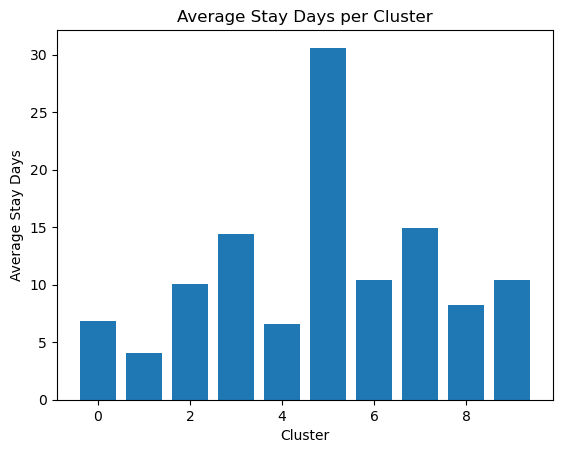

In [14]:
# Look at clusters
plot_data = clustered_df.groupby("cluster").mean()["stay_days"]
plot_x = plot_data.index
plot_y = plot_data.values
plt.bar(plot_x, plot_y)
plt.title("Average Stay Days per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Stay Days")

In [15]:
# Create a Table of mean values per cluster
cluster_mean_df = pd.DataFrame()
target_names = ["stay_days", "rachs", "cx_previous", "age_days"]

# Process each cluster's data
for i in range(N_CLUSTERS):
    c_df = clustered_df[clustered_df["cluster"] == i]
    targets = [c_df[t].mean() for t in target_names]
    cluster_mean_df[f"Cluster {i+1}"] = [c_df.count()[0], *targets]

# Rename Index
cluster_mean_df.index = ["n_patients", *target_names]
# Transpose and Sort Data
sort_by = "stay_days"
cluster_mean_df = cluster_mean_df.transpose().sort_values(by=sort_by)
print("Table of Cluster x Mean Values")
cluster_mean_df

Table of Cluster x Mean Values


,n_patients,stay_days,rachs,cx_previous,age_days
Cluster 2,184.0,4.097826,1.760870,0.320652,3837.711957
Cluster 5,5.0,6.600000,2.000000,0.200000,593.400000
Cluster 1,102.0,6.813725,1.950980,0.039216,900.156863
Cluster 9,5.0,8.200000,2.400000,0.400000,1933.000000
Cluster 3,377.0,10.039788,2.233422,0.169761,901.684350
Cluster 7,7.0,10.428571,2.000000,0.000000,1213.000000
Cluster 10,9.0,10.444444,2.333333,0.444444,1151.222222
Cluster 4,268.0,14.402985,2.440299,0.179104,733.552239
Cluster 8,41.0,14.951220,2.170732,0.073171,1291.951220
Cluster 6,5.0,30.600000,2.400000,0.200000,247.200000


In [16]:
# Getting More stats per Column, spread in different tables
target_stats = ["mean", "std", "min", "max"]
for i in range(N_CLUSTERS):
    print("CLUSTER:", i)
    d = clustered_df[clustered_df["cluster"] == i]
    print(d[target_names].describe().loc[target_stats])

CLUSTER: 0
      stay_days     rachs  cx_previous     age_days
mean   6.813725  1.950980     0.039216   900.156863
std    9.609948  0.680382     0.195066   765.689642
min    1.000000  0.000000     0.000000    77.000000
max   78.000000  3.000000     1.000000  3849.000000
CLUSTER: 1
      stay_days     rachs  cx_previous      age_days
mean   4.097826  1.760870     0.320652   3837.711957
std    4.295276  0.873027     0.754156   1760.570833
min    0.000000  0.000000     0.000000   1570.000000
max   39.000000  4.000000     4.000000  16378.000000
CLUSTER: 2
       stay_days     rachs  cx_previous     age_days
mean   10.039788  2.233422     0.169761   901.684350
std    25.544413  0.950166     0.475840   697.501578
min     0.000000  0.000000     0.000000     1.000000
max   364.000000  6.000000     3.000000  2719.000000
CLUSTER: 3
       stay_days     rachs  cx_previous     age_days
mean   14.402985  2.440299     0.179104   733.552239
std    20.430065  1.125205     0.447226   801.445815
min    

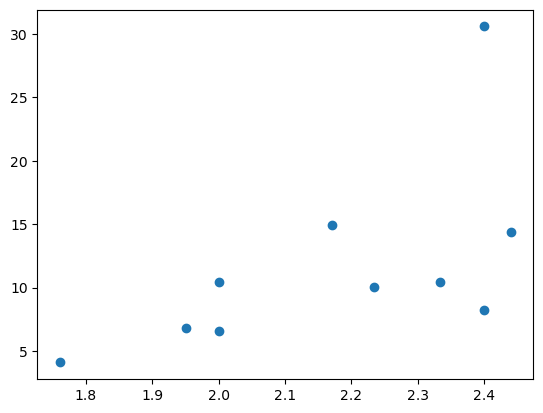

In [17]:
plt.scatter(cluster_mean_df['rachs'], cluster_mean_df['stay_days'])

In [18]:
# Format Results so they look better (They become strings)
cluster_mean_df.applymap(lambda x: f"{x:.2f}")

,n_patients,stay_days,rachs,cx_previous,age_days
Cluster 2,184.00,4.10,1.76,0.32,3837.71
Cluster 5,5.00,6.60,2.00,0.20,593.40
Cluster 1,102.00,6.81,1.95,0.04,900.16
Cluster 9,5.00,8.20,2.40,0.40,1933.00
Cluster 3,377.00,10.04,2.23,0.17,901.68
Cluster 7,7.00,10.43,2.00,0.00,1213.00
Cluster 10,9.00,10.44,2.33,0.44,1151.22
Cluster 4,268.00,14.40,2.44,0.18,733.55
Cluster 8,41.00,14.95,2.17,0.07,1291.95
Cluster 6,5.00,30.60,2.40,0.20,247.20


## Linear Regression

In [19]:
# Select Feature and Target
X = cluster_mean_df["rachs"].values.reshape(-1, 1)
y = cluster_mean_df["stay_days"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X.shape, y.shape

((10, 1), (10, 1))

In [20]:
# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([[10.47220573]])

In [21]:
# Predict and Evaluate Model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print("r-squared:", r2)
print("mean-squared error:", mse)
score = model.score(X_test, y_test)
print(score)

r-squared: 0.23060377051010328
mean-squared error: 38.54265615203754
-0.005937518152274723


Text(0, 0.5, 'Average Stay Days')

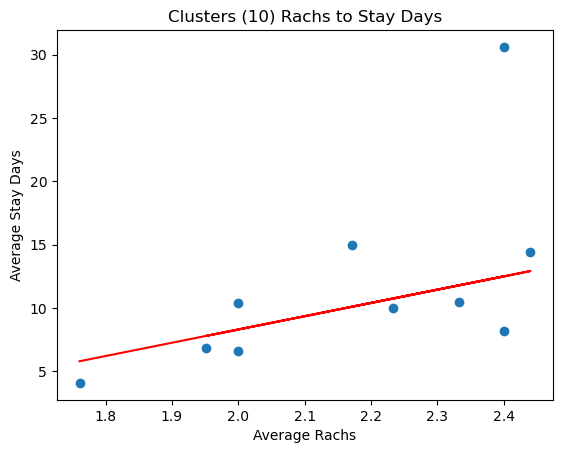

In [22]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title(f"Clusters ({N_CLUSTERS}) Rachs to Stay Days")
plt.xlabel("Average Rachs")
plt.ylabel("Average Stay Days")